In [1]:
import tensorflow as tf
import autokeras as ak

Using TensorFlow backend


### Load MNIST dataset


In [2]:
import numpy as np

num_instances = 1000

# Generate image data.
image_data = np.random.rand(num_instances, 32, 32, 3).astype(np.float32)
image_train, image_test = image_data[:800], image_data[800:]

# Generate structured data.
structured_data = np.random.choice(["a", "b", "c", "d", "e"], size=(num_instances, 3))
structured_train, structured_test = structured_data[:800], structured_data[800:]


# Generate classification labels of five classes.
classification_target = np.random.randint(5, size=num_instances)
clf_target_train, clf_target_test = (
    classification_target[:800],
    classification_target[800:],
)

# Generate regression targets.
regression_target = np.random.rand(num_instances, 1).astype(np.float32)
reg_target_train, reg_target_test = regression_target[:800], regression_target[800:]


In [3]:
structured_train[:5]


array([['c', 'd', 'b'],
       ['e', 'b', 'e'],
       ['d', 'e', 'd'],
       ['e', 'd', 'e'],
       ['e', 'd', 'd']], dtype='<U1')

### Run the ImageClassifier


In [4]:
import autokeras as ak

input_node1 = ak.ImageInput()
branch1 = ak.Normalization()(input_node1)
branch1 = ak.ConvBlock()(branch1)

input_node2 = ak.StructuredDataInput()
branch2 = ak.CategoricalToNumerical()(input_node2)
branch2 = ak.DenseBlock()(branch2)

merge_node = ak.Merge()([branch1, branch2])
output_node1 = ak.ClassificationHead()(merge_node)
output_node2 = ak.RegressionHead()(merge_node)


auto_model = ak.AutoModel(
    inputs=[input_node1, input_node2],
    outputs=[output_node1, output_node2],
    max_trials=3,
    overwrite=True,
    seed=42,
)

auto_model.fit(
    [image_train, structured_train],
    [clf_target_train, reg_target_train],
    epochs=3,
)


Trial 3 Complete [00h 00m 17s]
val_loss: 1.7056986093521118

Best val_loss So Far: 1.6978925466537476
Total elapsed time: 00h 00m 44s
Epoch 1/3
25/25 [==============================] - 4s 124ms/step - loss: 1.7701 - classification_head_1_loss: 1.6397 - regression_head_1_loss: 0.1304 - classification_head_1_accuracy: 0.1850 - regression_head_1_mean_squared_error: 0.1304
Epoch 2/3
25/25 [==============================] - 4s 162ms/step - loss: 1.7031 - classification_head_1_loss: 1.6095 - regression_head_1_loss: 0.0936 - classification_head_1_accuracy: 0.1988 - regression_head_1_mean_squared_error: 0.0936
Epoch 3/3
25/25 [==============================] - 2s 91ms/step - loss: 1.6927 - classification_head_1_loss: 1.6080 - regression_head_1_loss: 0.0847 - classification_head_1_accuracy: 0.2113 - regression_head_1_mean_squared_error: 0.0847


### Get the summarized results during the tuning process (return the best 10 models if
existed)


In [5]:
auto_model.tuner.results_summary()


Results summary
Results in ./auto_model
Showing 10 best trials
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 32
conv_block_1/dropout: 0.25
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
classification_head_1/dropout: 0
regression_head_1/dropout: 0
optimizer: adam
learning_rate: 0.001
Score: 1.6978925466537476
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 32
conv_block_1/dropout: 0.25
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
dense_block_1/use_batchnorm: False
d

### Retrieve best model


In [6]:
best_model = auto_model.export_model()
best_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 32, 32, 3)   0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['cast_to_float32[0][0]']        
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['normalization[0][0]']      

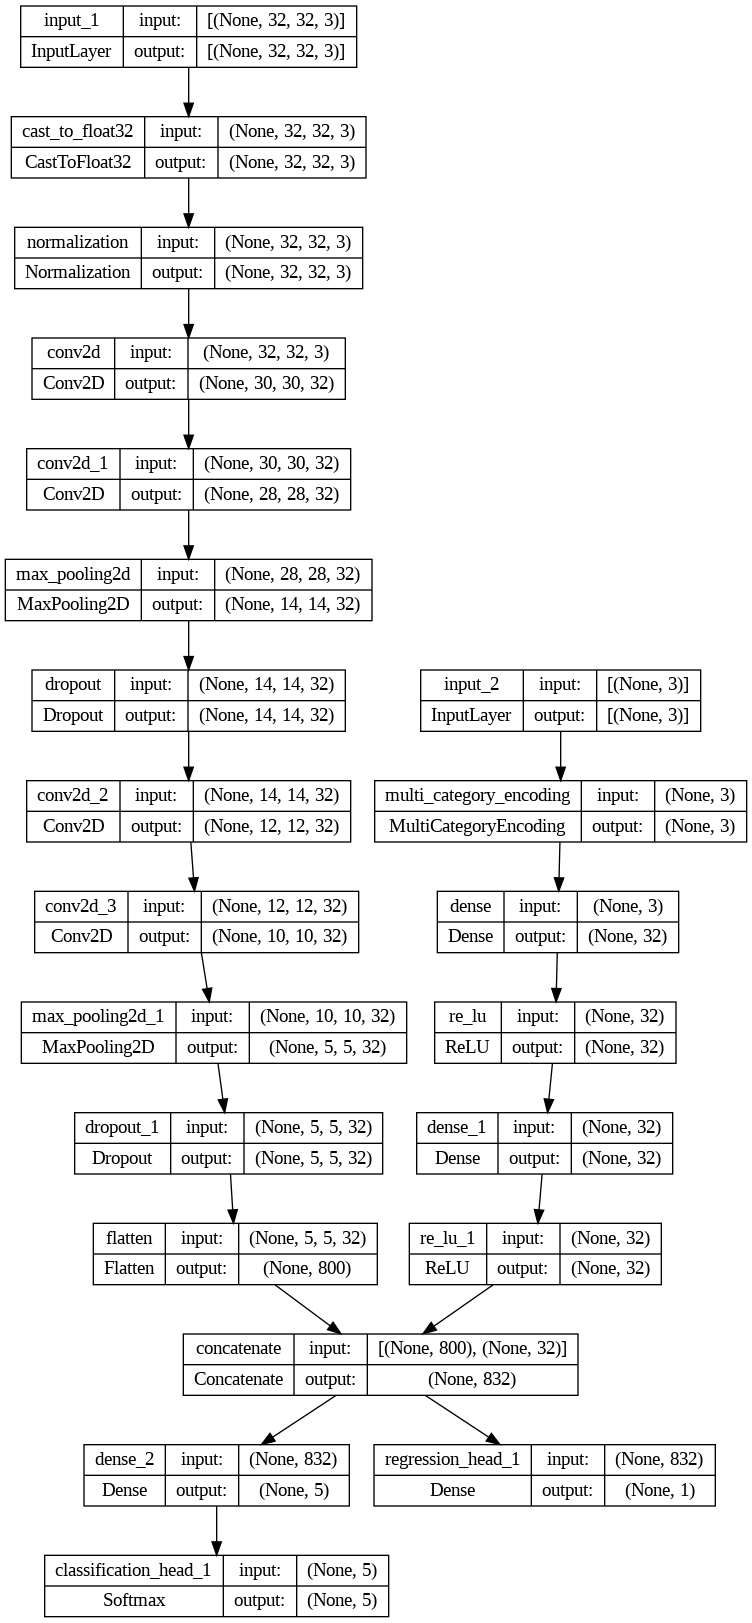

In [7]:
tf.keras.utils.plot_model(
    best_model, show_shapes=True, expand_nested=True
)  # rankdir='LR'


### Evaluate the best model on the test data.


In [8]:

total_loss, clf_loss, reg_loss, clf_acc, reg_mse = auto_model.evaluate(
    [image_test, structured_test],
    [clf_target_test, reg_target_test],
)
print("\nTotal testing loss: ", total_loss)
print("Classification testing cross-entropy loss: ", clf_loss)
print("Regression testing MSE loss: ", reg_loss)
print("Classification testing accuracy: ", clf_acc)
print("Regression testing MSE: ", reg_mse)


7/7 [==============================] - 1s 21ms/step - loss: 1.6992 - classification_head_1_loss: 1.6123 - regression_head_1_loss: 0.0869 - classification_head_1_accuracy: 0.1800 - regression_head_1_mean_squared_error: 0.0869

Total testing loss:  1.6991980075836182
Classification testing cross-entropy loss:  1.6123303174972534
Regression testing MSE loss:  0.08686753362417221
Classification testing accuracy:  0.18000000715255737
Regression testing MSE:  0.08686753362417221
